In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

trans = transforms.Compose([
    transforms.Resize((5, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

trainfolder = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
testfolder = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

trainloader = data.DataLoader(trainfolder, batch_size=128, shuffle=True, num_workers=4)
testloader = data.DataLoader(testfolder, batch_size=128, shuffle=False, num_workers=4)


In [2]:
class MNISTAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(16, 8)
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.Unflatten(1, (16, 1, 1)),
            nn.ConvTranspose2d(16, 8, kernel_size=3),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size=3),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

ae = MNISTAE().cuda()
loss_function = nn.MSELoss()
adam = optim.Adam(ae.parameters(), lr=1e-3)


In [3]:
for epoch in range(20):
    ae.train()
    train_loss = 0
    for x, _ in tqdm(trainloader):
        x = x.cuda().float()
        adam.zero_grad()
        x_pred, _ = ae(x)
        loss = loss_function(x_pred, x)
        loss.backward()
        adam.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(trainloader)}")



100%|██████████| 469/469 [00:01<00:00, 254.55it/s]


Epoch 1, Train Loss: 0.15627446731747086


100%|██████████| 469/469 [00:01<00:00, 257.58it/s]


Epoch 2, Train Loss: 0.036381462128209405


100%|██████████| 469/469 [00:01<00:00, 280.77it/s]


Epoch 3, Train Loss: 0.027231423593342685


100%|██████████| 469/469 [00:01<00:00, 276.51it/s]


Epoch 4, Train Loss: 0.023087561599163614


100%|██████████| 469/469 [00:01<00:00, 265.67it/s]


Epoch 5, Train Loss: 0.02208866633331852


100%|██████████| 469/469 [00:01<00:00, 269.97it/s]


Epoch 6, Train Loss: 0.021182010005881536


100%|██████████| 469/469 [00:01<00:00, 287.05it/s]


Epoch 7, Train Loss: 0.020207081550061068


100%|██████████| 469/469 [00:01<00:00, 269.11it/s]


Epoch 8, Train Loss: 0.01984225600354199


100%|██████████| 469/469 [00:01<00:00, 273.98it/s]


Epoch 9, Train Loss: 0.01962840619848481


100%|██████████| 469/469 [00:01<00:00, 278.22it/s]


Epoch 10, Train Loss: 0.01945757664350876


100%|██████████| 469/469 [00:01<00:00, 290.40it/s]


Epoch 11, Train Loss: 0.019310718519426485


100%|██████████| 469/469 [00:01<00:00, 275.37it/s]


Epoch 12, Train Loss: 0.019180074288472057


100%|██████████| 469/469 [00:01<00:00, 267.12it/s]


Epoch 13, Train Loss: 0.019067444352071677


100%|██████████| 469/469 [00:01<00:00, 273.34it/s]


Epoch 14, Train Loss: 0.01893116973006903


100%|██████████| 469/469 [00:01<00:00, 282.65it/s]


Epoch 15, Train Loss: 0.018767339042397833


100%|██████████| 469/469 [00:01<00:00, 256.99it/s]


Epoch 16, Train Loss: 0.018429596272946547


100%|██████████| 469/469 [00:01<00:00, 263.20it/s]


Epoch 17, Train Loss: 0.018052178478714372


100%|██████████| 469/469 [00:01<00:00, 257.73it/s]


Epoch 18, Train Loss: 0.017883987219603076


100%|██████████| 469/469 [00:01<00:00, 284.67it/s]


Epoch 19, Train Loss: 0.017799050275133108


100%|██████████| 469/469 [00:01<00:00, 281.78it/s]

Epoch 20, Train Loss: 0.017729614126577434


In [4]:
ae.eval()
embeddings, labels = [], []

with torch.no_grad():
    for x, y in tqdm(testloader):
        x = x.cuda().float()
        _, z = ae(x)
        embeddings.append(z.cpu().numpy())
        labels.append(y.cpu().numpy())

embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

torch.save(ae.state_dict(), "mnist_conv_autoencoder_weights.pth")


100%|██████████| 79/79 [00:00<00:00, 239.80it/s]


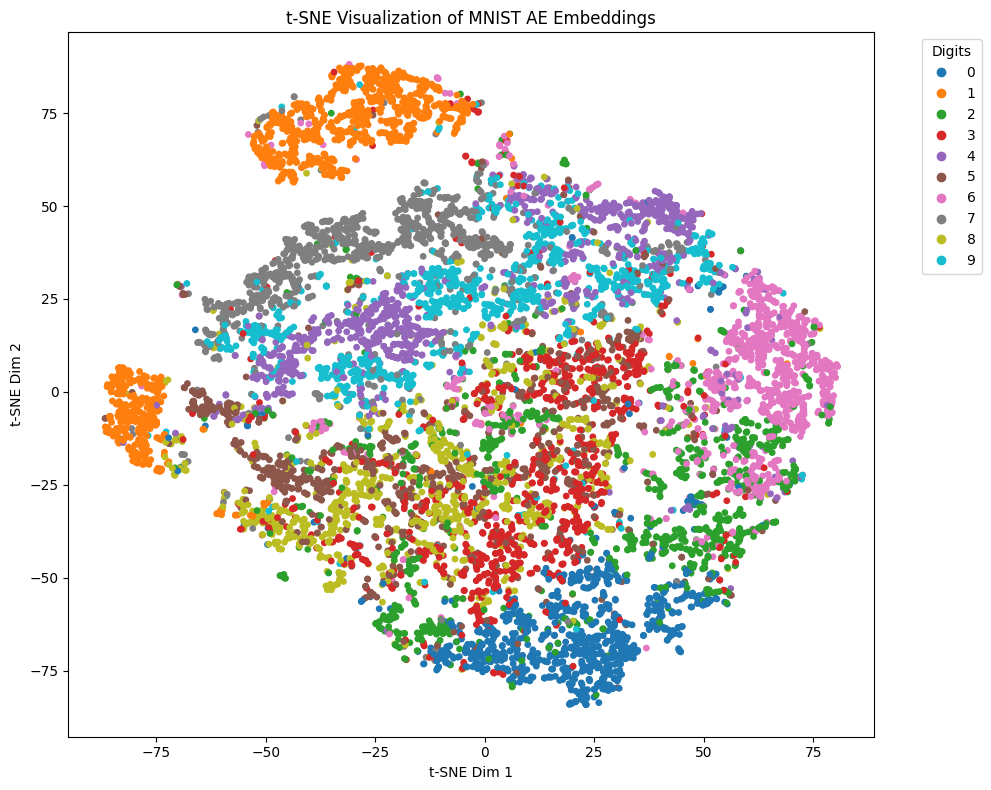

<Figure size 640x480 with 0 Axes>

In [5]:
# t-SNE visualization
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', s=15)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title('t-SNE Visualization of MNIST AE Embeddings')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.tight_layout()
plt.show()
plt.savefig("tsne_mnist_ae.png")